#PYTHON INSTALACJA

In [ ]:
%%shell
#pip install pytorch-lightning --quiet
#pip install wandb --quiet
pip install hydra-core --upgrade --quiet
pip install unzip --quiet
pip install ipdb -Uqq

     |████████████████████████████████| 153 kB 5.0 MB/s 
     |████████████████████████████████| 117 kB 51.6 MB/s 
     |████████████████████████████████| 79 kB 6.7 MB/s 


#PYTHON PAKIETY

In [ ]:
# standardowe pakiety
import os
from os.path import join, isfile
from os import listdir
import numpy as np
from scipy.io import loadmat
import scipy as sp
from PIL import Image
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random
import glob
import ipdb
from __future__ import print_function
from tqdm import tqdm

# Pytorch 
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split
import torch.utils.data as data
from torchvision.datasets import CIFAR10
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, ToPILImage, Normalize, Resize, ToTensor
from torch.autograd import Variable
'''
# Pytorch Lightning related imports
import pytorch_lightning as pl
from pytorch_lightning.callbacks import Callback
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint
import torchmetrics
'''
# Hydra
import hydra
from hydra.utils import instantiate
from omegaconf import DictConfig, OmegaConf
'''
# Weights and Biases
import wandb
'''

'\n# Weights and Biases\nimport wandb\n'

#POBIERANIE DANYCH

In [ ]:
! wget http://modelnet.cs.princeton.edu/ModelNet40.zip

--2022-12-14 14:56:21--  http://modelnet.cs.princeton.edu/ModelNet40.zip
Resolving modelnet.cs.princeton.edu (modelnet.cs.princeton.edu)... 128.112.136.74
Connecting to modelnet.cs.princeton.edu (modelnet.cs.princeton.edu)|128.112.136.74|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://modelnet.cs.princeton.edu/ModelNet40.zip [following]
--2022-12-14 14:56:21--  https://modelnet.cs.princeton.edu/ModelNet40.zip
Connecting to modelnet.cs.princeton.edu (modelnet.cs.princeton.edu)|128.112.136.74|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2039180837 (1.9G) [application/zip]
Saving to: ‘ModelNet40.zip.1’

ModelNet40.zip.1      2%[                    ]  51.50M  24.7MB/s               ^C


In [ ]:
%%shell
mkdir /content/model40
unzip -qq /content/ModelNet40.zip -d /content/model40

mkdir: cannot create directory ‘model’: File exists
replace /content/model/ModelNet40/stairs/train/stairs_0011.off? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
! wget http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip

--2022-12-14 21:25:10--  http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip
Resolving 3dvision.princeton.edu (3dvision.princeton.edu)... 128.112.136.74
Connecting to 3dvision.princeton.edu (3dvision.princeton.edu)|128.112.136.74|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip [following]
--2022-12-14 21:25:10--  https://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip
Connecting to 3dvision.princeton.edu (3dvision.princeton.edu)|128.112.136.74|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 473402300 (451M) [application/zip]
Saving to: ‘ModelNet10.zip.1’

ModelNet10.zip.1    100%[===================>] 451.47M  97.6MB/s    in 4.7s    

2022-12-14 21:25:15 (96.0 MB/s) - ‘ModelNet10.zip.1’ saved [473402300/473402300]



In [ ]:
%%shell
mkdir /content/model10
unzip -qq /content/ModelNet10.zip -d /content/model10

#DEFAULT LOADER AND READER

In [ ]:
'''
def default_loader(path, numpoints):
    myF = open(path, 'r')
    firstLine = myF.readline().strip()
    if 'OFF' != firstLine[0:3]:
        raise ValueError('Not a valid OFF header')
    if len(firstLine) > 3:
        n_verts, n_faces, n_edges = tuple([int(s) for s in firstLine[4:].split(' ')])
    else:
        n_verts, n_faces, n_edges = tuple([int(s) for s in myF.readline().strip().split(' ')])
    verts = np.array([[float(s) for s in myF.readline().strip().split(' ')] for i_vert in range(n_verts)])
    #if verts.shape[0] == 0: return
    choice = np.random.choice(verts.shape[0], numpoints, replace=True)
    
    choice = None
    iter = 0
    while choice is None:
        try:
            choice = np.random.choice(verts.shape[0], numpoints, replace=True)
            iter = iter + 1
        except:
            pass
        if (iter == 20): break
    
    point_set = verts[choice, :]
    #faces = [[int(s) for s in myF.readline().strip().split(' ')][1:] for i_face in range(n_faces)]
    point_set = point_set - np.expand_dims(np.mean(point_set, axis=0), 0)  # center
    dist = np.max(np.sqrt(np.sum(point_set ** 2, axis=1)), 0)
    point_set = point_set / dist  # scale
    point_set = torch.from_numpy(point_set).float()
    return point_set

def default_flist_reader(flist):
    imlist = []
    main_data_folder_string = "./model10/ModelNet10/"

    classes_dirs = glob.glob(main_data_folder_string + "*/", recursive = False)
    classes_list = [i.split('/')[3] for i in classes_dirs]
    classes_nums = np.linspace(0,39,40)
    classes_dict = dict(zip(sorted(classes_list), classes_nums.astype(int)))

    for line in flist:
        label_start_index = line.strip().find(main_data_folder_string) + len(main_data_folder_string)
        label_end_index = line.strip()[label_start_index:].find('/')
        imlabel = line.strip()[label_start_index:label_start_index+label_end_index]
        imlabel = classes_dict[imlabel]
        impath = line
        imlist.append( (impath, imlabel) )
    return imlist
'''


#MODELNET LOADER

In [ ]:
del data

In [ ]:
class ModelNetLoader(data.Dataset):
    def __init__(self, root, split='train', numpoints=5000, batch_size=32, transform=None, target_transform=None):
        self.root = root
        self.numpoints = numpoints
        self.num_classes = 10
        self.batch_size = batch_size
        self.filelist = [f1 for f1 in glob.glob(self.root + '**/*.off', recursive=True)]# if isfile(join(self.data_dir, f1))]
        self.trainlist = [f2 for f2 in self.filelist if "train" in f2]
        self.testlist = [f3 for f3 in self.filelist if "test" in f3]
        if split=='train': self.objlist = self.flist_reader(self.trainlist)
        if split=='test': self.objlist = self.flist_reader(self.testlist)
        self.transform = transform
        self.target_transform = target_transform

    def __getitem__(self, index):
        impath, target = self.objlist[index]
        myF = open(impath, 'r')
        firstLine = myF.readline().strip()
        if 'OFF' != firstLine[0:3]:
            raise ValueError('Not a valid OFF header')
        if len(firstLine) > 3:
            n_verts, n_faces, n_edges = tuple([int(s) for s in firstLine[4:].split(' ')])
        else:
            n_verts, n_faces, n_edges = tuple([int(s) for s in myF.readline().strip().split(' ')])
        verts = np.array([[float(s) for s in myF.readline().strip().split(' ')] for i_vert in range(n_verts)])
        #if verts.shape[0] == 0: return
        choice = np.random.choice(verts.shape[0], self.numpoints, replace=True)
        '''
        choice = None
        iter = 0
        while choice is None:
            try:
                choice = np.random.choice(verts.shape[0], numpoints, replace=True)
                iter = iter + 1
            except:
                pass
            if (iter == 20): break
        '''
        point_set = verts[choice, :]
        #faces = [[int(s) for s in myF.readline().strip().split(' ')][1:] for i_face in range(n_faces)]
        point_set = point_set - np.expand_dims(np.mean(point_set, axis=0), 0)  # center
        dist = np.max(np.sqrt(np.sum(point_set ** 2, axis=1)), 0)
        point_set = point_set / dist  # scale
        #poniższe dwie linijki nowe
        point_set = torch.from_numpy(point_set.astype(np.float32)).float()
        #target = torch.from_numpy(np.array([target]).astype(np.int64))
        return point_set, target

    def flist_reader(self, filelist):
        classes_dirs = glob.glob(self.root + "*/", recursive = False)
        classes_list = [i.split('/')[4] for i in classes_dirs]
        classes_nums = np.linspace(0,self.num_classes-1,self.num_classes)
        classes_dict = dict(zip(sorted(classes_list), classes_nums.astype(int)))
        objlist = []

        for line in filelist:
            label_start_index = line.strip().find(self.root) + len(self.root)
            label_end_index = line.strip()[label_start_index:].find('/')
            imlabel = line.strip()[label_start_index:label_start_index+label_end_index]
            imlabel = classes_dict[imlabel]
            impath = line
            objlist.append( (impath, imlabel) )
        return objlist

    def __len__(self):
      return len(self.objlist)

    #def train_dataloader(self):
    #    return DataLoader(dataset=self, batch_size=self.batch_size, num_workers=self.num_workers, shuffle=self.shuf)

In [ ]:
mdltest = ModelNetLoader(root='/content/model10/ModelNet10/')

In [ ]:
def disp(tensor_image, target):
    fig = plt.figure(figsize=(10, 10))
    ax = plt.axes(projection='3d')
    V_np = np.asarray(tensor_image.cpu())
    xx = V_np[:, 0]
    yy = V_np[:, 1]
    zz = V_np[:, 2]
    ax.scatter(xx, yy, zz)
    plt.axis('off')
    plt.show()
    print('Etykieta klasy: {}'.format(target))
    print()

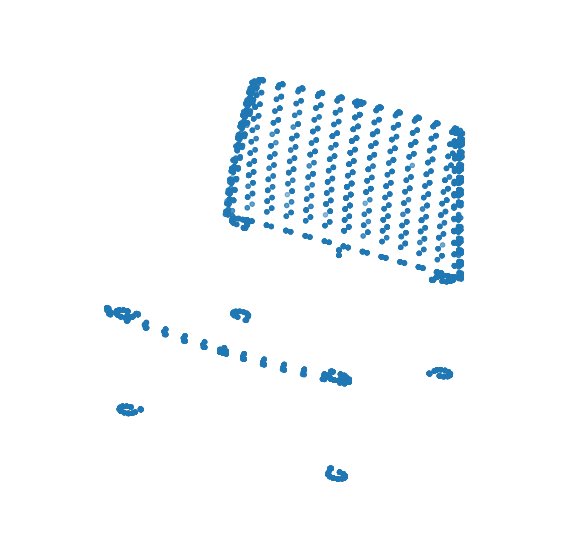

Etykieta klasy: 2



In [ ]:
xxx = mdltest[628]
disp(xxx[0], xxx[1])

#MODELNET DATA MODULE

In [ ]:
'''
class ModelNetDataModule(pl.LightningDataModule):
    def __init__(self, batch_size, npoints=100, nworkers=1, data_dir: str = './model10/ModelNet10/'):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.num_classes = 10
        self.npoints = npoints
        self.nworkers = nworkers
        self.imglist = [f1 for f1 in glob.glob(data_dir + '**/*.off', recursive=True)]# if isfile(join(self.data_dir, f1))]
        self.trainlist = [f2 for f2 in self.imglist if "train" in f2]
        self.testlist = [f3 for f3 in self.imglist if "test" in f3]


    def setup(self, stage=None):
        #training / validation
        if stage == 'fit' or stage is None:
            train_dataset = ModelNetFileList(root=self.data_dir, numpoints=self.npoints, flist=self.trainlist)
            train_dataset_size = int(len(train_dataset) * 0.9)
            self.train_dataset, self.val_dataset = random_split(train_dataset, [train_dataset_size, len(train_dataset) - train_dataset_size])
        #testing
        if stage == 'test' or stage is None:
            self.test_dataset = ModelNetFileList(root=self.data_dir, numpoints=self.npoints, flist=self.testlist)

    def prepare_batch(self):
        batch_tensor = torch.empty((self.batch_size, 3, self.npoints))
        for n in range(self.batch_size):
            obj, target = random.choice(self.train_dataset) 
            obj = obj.view(obj.shape[1], obj.shape[0])
            batch_tensor[n, :, :] = obj
        self.batch_tensor = batch_tensor

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, num_workers=self.nworkers, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, num_workers=self.nworkers)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, num_workers=self.nworkers)
'''

In [ ]:
class ModelNetDataset(data.Dataset):
    def __init__(self,
                 root,
                 npoints=2500,
                 split='train',
                 data_augmentation=True):
        self.npoints = npoints
        self.root = root
        self.split = split
        self.data_augmentation = data_augmentation
        self.fns = []
        with open(os.path.join(root, '{}.txt'.format(self.split)), 'r') as f:
            for line in f:
                self.fns.append(line.strip())

        self.cat = {}
        with open('./misc/modelnet_id.txt', 'r') as f:
            for line in f:
                ls = line.strip().split()
                self.cat[ls[0]] = int(ls[1])

        print(self.cat)
        self.classes = list(self.cat.keys())
    '''
    def __getitem2__(self, index):
      #impath, target = self.imlist[index]
      myF = open(os.path.join(self.root, '{}.txt'.format(self.split)), 'r')
      firstLine = myF.readline().strip()
      if 'OFF' != firstLine[0:3]:
          raise ValueError('Not a valid OFF header')
      if len(firstLine) > 3:
          n_verts, n_faces, n_edges = tuple([int(s) for s in firstLine[4:].split(' ')])
      else:
          n_verts, n_faces, n_edges = tuple([int(s) for s in myF.readline().strip().split(' ')])
      verts = torch.tensor([[float(s) for s in myF.readline().strip().split(' ')] for i_vert in range(n_verts)])
      #ipdb.set_trace(context=5)#
      if verts.shape[0] > 0:
        choice = np.random.choice(verts.shape[0], numpoints, replace=True)
        point_set = verts[choice, :]
      else:
        point_set=verts 
      #faces = [[int(s) for s in myF.readline().strip().split(' ')][1:] for i_face in range(n_faces)]
      return point_set, target

    def __len__(self):
        return len(self.fns)
    '''


    def __getitem__(self, index):
        ###ipdb.set_trace(context=5)#
        fn = self.fns[index]
        cls = self.cat[fn.split('/')[0]]
        #ipdb.set_trace(context=5)#

        '''
        with open(os.path.join(self.root, fn), 'rb') as f:
            plydata = PlyData.read(f)
        pts = np.vstack([plydata['vertex']['x'], plydata['vertex']['y'], plydata['vertex']['z']]).T
        
        '''
        ipdb.set_trace(context=5)
        with open(os.path.join(self.root, fn), 'r') as myF:
            firstLine = myF.readline().strip()
            #if 'OFF' != firstLine[0:3]:
            #    raise ValueError('Not a valid OFF header')
            if len(firstLine) > 3:
                n_verts, n_faces, n_edges = tuple([int(s) for s in firstLine[4:].split(' ')])
            else:
                n_verts, n_faces, n_edges = tuple([int(s) for s in myF.readline().strip().split(' ')])
            pts = torch.tensor([[float(s) for s in myF.readline().strip().split(' ')] for i_vert in range(n_verts)])       

        

        choice = np.random.choice(len(pts), self.npoints, replace=True)
        point_set = pts[choice, :]

        point_set = point_set - np.expand_dims(np.mean(point_set, axis=0), 0)  # center
        dist = np.max(np.sqrt(np.sum(point_set ** 2, axis=1)), 0)
        point_set = point_set / dist  # scale

        if self.data_augmentation:
            theta = np.random.uniform(0, np.pi * 2)
            rotation_matrix = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
            point_set[:, [0, 2]] = point_set[:, [0, 2]].dot(rotation_matrix)  # random rotation
            point_set += np.random.normal(0, 0.02, size=point_set.shape)  # random jitter

        point_set = torch.from_numpy(point_set.astype(np.float32))
        cls = torch.from_numpy(np.array([cls]).astype(np.int64))
        return point_set, cls        

#LOAD SAMPLE DATA

Rozmiar zbioru treningowego: 3591
Rozmiar zbioru walidacyjnego: 400
Rozmiar zbioru testowego: 908


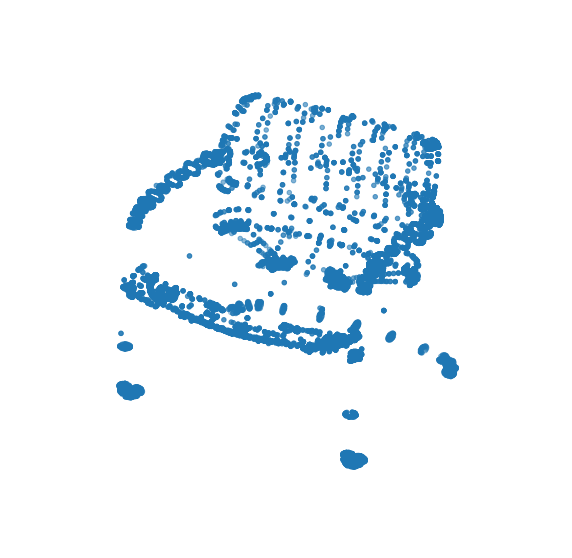

Etykieta klasy: 2



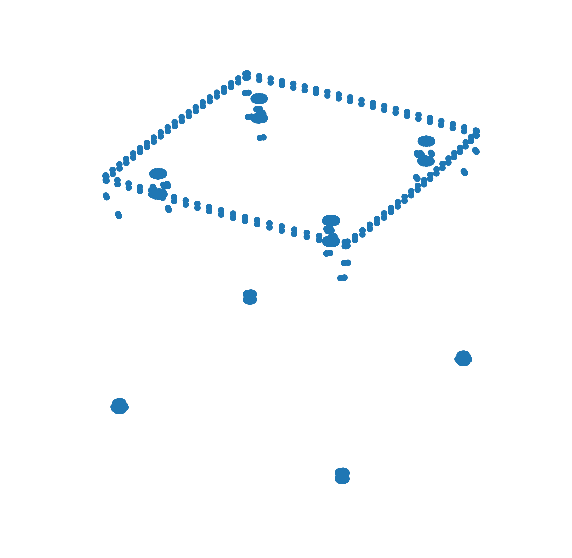

Etykieta klasy: 8



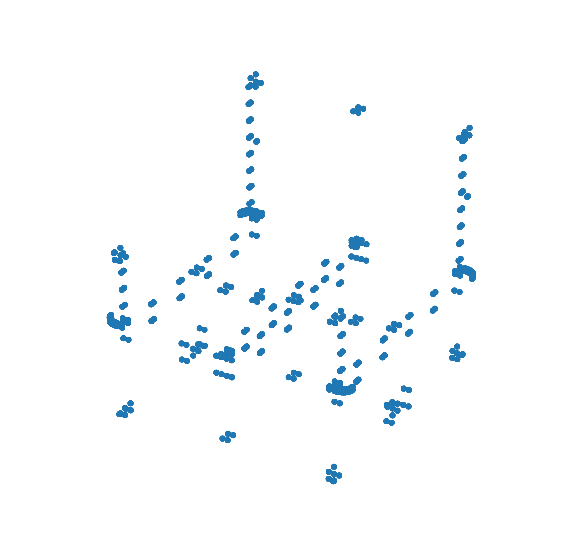

Etykieta klasy: 1



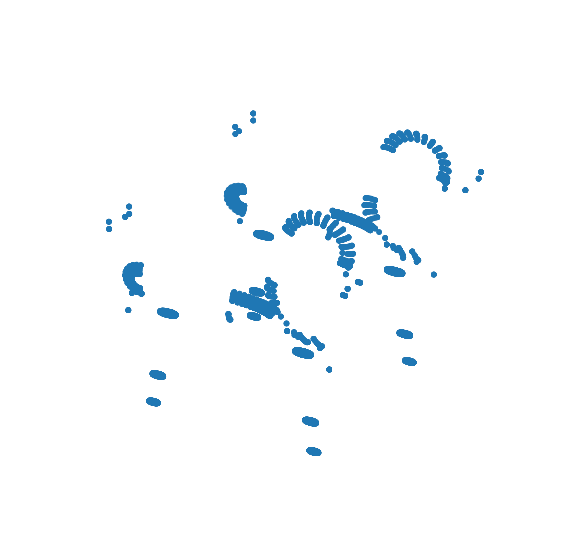

Etykieta klasy: 7



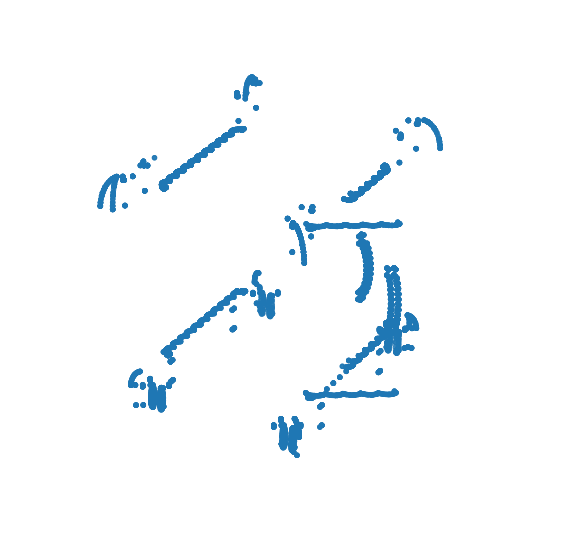

Etykieta klasy: 8



In [ ]:
sample_data = ModelNetDataModule(batch_size=10, npoints=12000)
sample_data.setup()
sample_data.prepare_batch()

print("Rozmiar zbioru treningowego: " + str(len(sample_data.train_dataset)))
print("Rozmiar zbioru walidacyjnego: " + str(len(sample_data.val_dataset)))
print("Rozmiar zbioru testowego: " + str(len(sample_data.test_dataset)))


def show_examples(dataset, n):
    for i in range(n):
        tensor_image, target = random.choice(dataset)
        #ipdb.set_trace(context=5)
        fig = plt.figure(figsize=(10, 10))
        ax = plt.axes(projection='3d')
        V_np = np.asarray(tensor_image)

        #print(V_np.size0
        #print(V_np)
        xx = V_np[:, 0]
        yy = V_np[:, 1]
        zz = V_np[:, 2]
        ax.scatter(xx, yy, zz)
        plt.axis('off')
        plt.show()

        print('Etykieta klasy: {}'.format(target))
        print()
  
show_examples(sample_data.train_dataset, 5)

#dir(sample_data)

#STN3D

In [ ]:
class STN3d(nn.Module):
    def __init__(self, channel=3):
        super(STN3d, self).__init__()
        self.conv1 = torch.nn.Conv1d(channel, 64, 1)
        self.conv2 = torch.nn.Conv1d(64, 128, 1)
        self.conv3 = torch.nn.Conv1d(128, 1024, 1)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 9)
        self.relu = nn.ReLU()
        '''
        self.bn1 = nn.BatchNorm1d(64) 
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.bn4 = nn.BatchNorm1d(512)
        self.bn5 = nn.BatchNorm1d(256)
        '''
        self.bns = []
        batch_norm_args = np.logspace(6, 10, base=2, num=5, dtype=np.int64)
        for n in batch_norm_args: self.bns.append(nn.BatchNorm1d(n)) 


    def forward(self, x):
        batchsize = x.shape[0]
        x = F.relu(self.bns[0](self.conv1(x)))
        x = F.relu(self.bns[1](self.conv2(x)))
        x = F.relu(self.bns[4](self.conv3(x)))
        x = torch.max(x, 2, keepdim=True)[0]
        x = x.view(-1, 1024) 
        x = F.relu(self.bns[3](self.fc1(x))) 
        x = F.relu(self.bns[2](self.fc2(x)))
        x = self.fc3(x)
        iden = Variable(torch.from_numpy(np.array([1, 0, 0, 0, 1, 0, 0, 0, 1]).astype(np.float32))).view(1, 9).repeat(batchsize, 1)
        if x.is_cuda:
            iden = iden.cuda()
        x = x + iden
        x = x.view(-1, 3, 3)
        return x


#STNKD

In [ ]:
class STNkd(nn.Module):
    def __init__(self, k=64):
        super(STNkd, self).__init__()
        self.conv1 = torch.nn.Conv1d(k, 64, 1)
        self.conv2 = torch.nn.Conv1d(64, 128, 1)
        self.conv3 = torch.nn.Conv1d(128, 1024, 1)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, k*k)
        self.relu = nn.ReLU()
        '''
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.bn4 = nn.BatchNorm1d(512)
        self.bn5 = nn.BatchNorm1d(256)
        '''
        self.bns = []
        batch_norm_args = np.logspace(6, 10, base=2, num=5, dtype=np.int64)
        for n in batch_norm_args: self.bns.append(nn.BatchNorm1d(n)) 

        self.k = k

    def forward(self, x):
        batchsize = x.shape[0]
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = torch.max(x, 2, keepdim=True)[0]
        x = x.view(-1, 1024)

        x = F.relu(self.bn4(self.fc1(x)))
        x = F.relu(self.bn5(self.fc2(x)))
        x = self.fc3(x)

        iden = Variable(torch.from_numpy(np.eye(self.k).flatten().astype(np.float32))).view(1,self.k*self.k).repeat(batchsize,1) #stare, zmienić
        if x.is_cuda:
            iden = iden.cuda()#pytorch lightning
        x = x + iden
        x = x.view(-1, self.k, self.k)
        return x

In [ ]:
class STN(nn.Module):
    def __init__(self, kd=True):
        if kd:  self.k=64; self.iden_arr=np.eye(self.k).flatten()
        else:   self.k=3;  self.iden_arr=np.array([1, 0, 0, 0, 1, 0, 0, 0, 1]) 
        super(STN, self).__init__()
        self.conv1 = torch.nn.Conv1d(self.k, 64, 1)
        self.conv2 = torch.nn.Conv1d(64, 128, 1)
        self.conv3 = torch.nn.Conv1d(128, 1024, 1)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, self.k*self.k)
        self.relu = nn.ReLU()

        self.bns = []
        batch_norm_args = np.logspace(6, 10, base=2, num=5, dtype=np.int64)
        for n in batch_norm_args: self.bns.append(nn.BatchNorm1d(n)) 

    def forward(self, x):
        batchsize = x.shape[0]
        x = F.relu(self.bns[0](self.conv1(x)))
        x = F.relu(self.bns[1](self.conv2(x)))
        x = F.relu(self.bns[4](self.conv3(x)))
        x = torch.max(x, 2, keepdim=True)[0]
        x = x.view(-1, 1024) 
        x = F.relu(self.bns[3](self.fc1(x))) 
        x = F.relu(self.bns[2](self.fc2(x)))
        x = self.fc3(x)
        iden = Variable(torch.from_numpy(self.iden_arr.astype(np.float32))).view(1, self.k*self.k).repeat(batchsize, 1) #stare, zmienić

        if x.is_cuda:
            iden = iden.cuda()#pytorch lightning, tako rzeczye Gwardys
        x = x + iden
        x = x.view(-1, self.k, self.k)
        return x

#POINTNET FEATURE

In [ ]:
class PointNetfeat(nn.Module):
    def __init__(self, global_feat = True, feature_transform = False):
        super(PointNetfeat, self).__init__()
        self.stn = STN(kd=False)
        self.conv1 = torch.nn.Conv1d(3, 64, 1)
        self.conv2 = torch.nn.Conv1d(64, 128, 1)
        self.conv3 = torch.nn.Conv1d(128, 1024, 1)
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.global_feat = global_feat
        self.feature_transform = feature_transform
        if self.feature_transform:
            self.fstn = STN()

    def forward(self, x):
        n_pts = x.shape[2]
        trans = self.stn(x)
        #ipdb.set_trace(context=5)
        x = x.transpose(2, 1)
        x = torch.bmm(x, trans)
        x = x.transpose(2, 1)
        x = F.relu(self.bn1(self.conv1(x)))

        if self.feature_transform:
            trans_feat = self.fstn(x)
            x = x.transpose(2,1)
            x = torch.bmm(x, trans_feat)
            x = x.transpose(2,1)
        else:
            trans_feat = None

        pointfeat = x
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.bn3(self.conv3(x))
        x = torch.max(x, 2, keepdim=True)[0]
        x = x.view(-1, 1024)
        if self.global_feat:
            return x, trans, trans_feat
        else:
            x = x.view(-1, 1024, 1).repeat(1, 1, n_pts)
            return torch.cat([x, pointfeat], 1), trans, trans_feat


def feature_transform_regularizer(trans):
    d = trans.size()[1]
    batchsize = trans.size()[0]
    I = torch.eye(d)[None, :, :]
    if trans.is_cuda:
        I = I.cuda()
    loss = torch.mean(torch.norm(torch.bmm(trans, trans.transpose(2,1)) - I, dim=(1,2)))
    return loss

#POINTNET CLS

In [ ]:
class PointNetCls(nn.Module):
    def __init__(self, k=2, feature_transform=False):
        super(PointNetCls, self).__init__()
        self.feature_transform = feature_transform
        self.feat = PointNetfeat(global_feat=True, feature_transform=feature_transform)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, k)
        self.dropout = nn.Dropout(p=0.3)
        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)
        self.relu = nn.ReLU()

    def forward(self, x):
        x, trans, trans_feat = self.feat(x)
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.dropout(self.fc2(x))))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1), trans, trans_feat

In [ ]:
!nvidia-smi
!nvidia-smi -L  

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



#TRENOWANIE

In [ ]:
conf = OmegaConf.load('classification.yaml')
options = instantiate(conf)

blue = lambda x: '\033[94m' + x + '\033[0m'

options.manualSeed = random.randint(1, 10000)  # fix seed
print("Random Seed: ", options.manualSeed)
random.seed(options.manualSeed)
torch.manual_seed(options.manualSeed)

dataset = ModelNetLoader(root=options.dataset, batch_size=options.batch_size, split='train', numpoints=options.num_points)
testdataset = ModelNetLoader(root=options.dataset, batch_size=options.batch_size, split='test', numpoints=options.num_points)

traindataset_size = int(len(dataset) * 0.9)
traindataset, valdataset = random_split(dataset, [traindataset_size, len(dataset) - traindataset_size])
       
print("Rozmiar zbioru treningowego: " + str(len(traindataset)))
print("Rozmiar zbioru walidacyjnego: " + str(len(valdataset)))
print("Rozmiar zbioru testowego: " + str(len(testdataset)))
print("Rozmiar batcha: " + str(dataset.batch_size))
print('Liczba klas: ' + str(dataset.num_classes))

traindataloader = DataLoader(traindataset, batch_size=options.batch_size, num_workers=int(options.num_workers), shuffle=True)
valdataloader = DataLoader(valdataset, batch_size=options.batch_size, num_workers=int(options.num_workers), shuffle=True)
testdataloader = DataLoader(testdataset, batch_size=1, num_workers=int(options.num_workers), shuffle=False)

try:
    os.makedirs(options.out_folder)
except OSError:
    pass

classifier = PointNetCls(k=dataset.num_classes, feature_transform=options.feature_transform)

if options.model != '':
    classifier.load_state_dict(torch.load(options.model))

optimizer = optim.Adam(classifier.parameters(), lr=0.01, betas=(0.9, 0.999))
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)
################classifier.cuda()

num_batch = len(traindataset) / options.batch_size

'''
single_batch_overfit = torch.empty((options.batch_size, options.num_points, 3))
single_batch_overfit_cls = torch.empty((options.batch_size))

for n in range(options.batch_size):
  item = dataset[100*n]
  single_batch_overfit[n, :, :] = item[0]
  single_batch_overfit_cls[n] = item[1]
single_batch_overfit_cls = single_batch_overfit_cls.type(torch.int64)
'''

for epoch in range(options.num_epochs):
    scheduler.step()
    for i, data_ in enumerate(traindataloader, 0): #fir element in enumerate
        points, target = data_
        #points, target = single_batch_overfit, single_batch_overfit_cls
        #ipdb.set_trace(context=5)
        #target = target[:, 0]
        points = points.transpose(2, 1)
        ####################points, target = points.cuda(), target.cuda()
        optimizer.zero_grad()
        classifier = classifier.train()
        pred, trans, trans_feat = classifier(points)
        loss = F.nll_loss(pred, target)
        if options.feature_transform:
            loss += feature_transform_regularizer(trans_feat) * 0.001
        loss.backward()
        optimizer.step()
        pred_choice = pred.data.max(1)[1]
        correct = pred_choice.eq(target.data).cpu().sum()
        print('Epoch %d: batch %d of %d. Train loss: %f Accuracy: %f' % (epoch, i, num_batch, loss.item(), correct.item() / float(options.batch_size)))
        
        if i % 10 == 0:
            j, data_ = next(enumerate(valdataloader, 0))
            points, target = data_
            #points, target = single_batch_overfit, single_batch_overfit_cls
            #target = target[:, 0]
            points = points.transpose(2, 1)
            ###########################points, target = points.cuda(), target.cuda()
            classifier = classifier.eval()
            pred, _, _ = classifier(points)
            loss = F.nll_loss(pred, target)
            pred_choice = pred.data.max(1)[1]
            correct = pred_choice.eq(target.data).cpu().sum()
            print('Epoch %d: batch %d of %d. %s loss: %f Accuracy: %f' % (epoch, i, num_batch, blue('Validation'), loss.item(), correct.item()/float(options.batch_size)))
        
    torch.save(classifier.state_dict(), '%s/cls_model_%d.pth' % (options.out_folder, epoch))

total_correct = 0
total_testset = 0
print(blue("Testing"))

for i,data_ in tqdm(enumerate(testdataloader, 0)):
    points, target = data_
    #target = target[:, 0]
    points = points.transpose(2, 1)
    ###################points, target = points.cuda(), target.cuda()
    classifier = classifier.eval()
    pred, _, _ = classifier(points)
    pred_choice = pred.data.max(1)[1]
    correct = pred_choice.eq(target.data).cpu().sum()
    total_correct += correct.item()
    total_testset += points.size()[0]

print("\nFinal accuracy: {}".format(total_correct / float(total_testset)))

Random Seed:  1555
Rozmiar zbioru treningowego: 3591
Rozmiar zbioru walidacyjnego: 400
Rozmiar zbioru testowego: 908
Rozmiar batcha: 50
Liczba klas: 10
Epoch 0: batch 0 of 71. Train loss: 2.464597 Accuracy: 0.080000
Epoch 0: batch 0 of 71. Validation loss: 8.436953 Accuracy: 0.120000
Epoch 0: batch 1 of 71. Train loss: 3.032526 Accuracy: 0.020000
Epoch 0: batch 2 of 71. Train loss: 3.061309 Accuracy: 0.280000
Epoch 0: batch 3 of 71. Train loss: 2.708909 Accuracy: 0.420000
Epoch 0: batch 4 of 71. Train loss: 2.418524 Accuracy: 0.380000
Epoch 0: batch 5 of 71. Train loss: 2.431446 Accuracy: 0.360000
Epoch 0: batch 6 of 71. Train loss: 2.131029 Accuracy: 0.460000
Epoch 0: batch 7 of 71. Train loss: 2.079860 Accuracy: 0.460000
Epoch 0: batch 8 of 71. Train loss: 1.873102 Accuracy: 0.480000
Epoch 0: batch 9 of 71. Train loss: 2.281826 Accuracy: 0.360000
Epoch 0: batch 10 of 71. Train loss: 1.751853 Accuracy: 0.500000
Epoch 0: batch 10 of 71. Validation loss: 1.442552 Accuracy: 0.540000
Epoc

0it [00:00, ?it/s]


ValueError: ignored

In [ ]:
for i,data_ in tqdm(enumerate(testdataloader, 0)):
    points, target = data_
    #target = target[:, 0]
    #points = points.transpose(2, 1)
    ###################points, target = points.cuda(), target.cuda()
    classifier = classifier.eval()
    pred, _, _ = classifier(points)
    pred_choice = pred.data.max(1)[1]
    correct = pred_choice.eq(target.data).cpu().sum()
    total_correct += correct.item()
    total_testset += points.size()[0]

print("\nFinal accuracy: {}".format(total_correct / float(total_testset)))

0it [00:00, ?it/s]


RuntimeError: ignored

```python
class STN3d(nn.Module):
  output:
    stn torch.Size([32, 3, 3])global feat torch.Size([32, 1024])classification head:
      global feat torch.Size([32, 1024])
      point feat torch.Size([32, 1088, 2500])
      class torch.Size([32, 5])segmentation head:
        PointNetDenseCls(
          (feat): PointNetfeat(
            (stn): STN3d(
              (conv1): Conv1d(3, 64, kernel_size=(1,), stride=(1,))
              (conv2): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
              (conv3): Conv1d(128, 1024, kernel_size=(1,), stride=(1,))
              (mp1): MaxPool1d(kernel_size=2500, stride=2500, padding=0, dilation=1, ceil_mode=False)
              (fc1): Linear(in_features=1024, out_features=512, bias=True)
              (fc2): Linear(in_features=512, out_features=256, bias=True)
              (fc3): Linear(in_features=256, out_features=9, bias=True)
              (relu): ReLU()
              (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (bn3): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (bn4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (bn5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            )
            (conv1): Conv1d(3, 64, kernel_size=(1,), stride=(1,))
            (conv2): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
            (conv3): Conv1d(128, 1024, kernel_size=(1,), stride=(1,))
            (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (bn3): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (mp1): MaxPool1d(kernel_size=2500, stride=2500, padding=0, dilation=1, ceil_mode=False)
          )
          (conv1): Conv1d(1088, 512, kernel_size=(1,), stride=(1,))
          (conv2): Conv1d(512, 256, kernel_size=(1,), stride=(1,))
          (conv3): Conv1d(256, 128, kernel_size=(1,), stride=(1,))
          (conv4): Conv1d(128, 3, kernel_size=(1,), stride=(1,))
          (bn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
  seg torch.Size([32, 2500, 3])
```